In [1]:
import torch
import pandas as pd
from TorchDataUtils import *
from NLPDataUtils import *

%matplotlib notebook
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Clasificación sin WordVectors

In [3]:
class AGNewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, root='./AG_NEWS/', preprocess=lambda x: x, train=True):
        
        target = 'train.csv' if train else 'test.csv'
        df = pd.read_csv(root + target, header=None, names=['class_idx', 'title', 'description'])
        
        # Etiquetas:
        self.cls_indeces = torch.tensor(df['class_idx'].tolist(), dtype=torch.long) - 1
        
        # DataSeries con las muestras de entradas:
        data = df['title']
        self.data = preprocess(data)
    
    def __getitem__(self,idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        return self.vectorizer.vectorize(self.data.iloc[idx]), self.cls_indeces[idx]
    
    def __len__(self):
        return len(self.cls_indeces)
    
    
def GetAGNewsDataset(root, preprocess, cutoff=25):
    
    # Datasets:
    train_dataset = AGNewsDataset(root, preprocess=preprocess, train=True)
    train_dataset.vectorizer = Vectorizer([train_dataset.data], cutoff=cutoff)
    test_dataset = AGNewsDataset(root, preprocess=preprocess, train=False)
    test_dataset.vectorizer = train_dataset.vectorizer
    
    # Dataloaders:
    train_dataloader, val_dataloader, test_dataloader = generate_data_batches(train_dataset, 
                                                                              test_dataset,    
                                                                              batch_size=64)
    return train_dataloader, val_dataloader, test_dataloader

def preprocess(data):
    df = data.str.replace(r'\(AP\)','')
    df = df.str.replace(r'\(Reuters\)','')
    df = df.str.replace(r'\(AFP\)','')
    df = df.str.replace(r'\(SPACE\.com\)','')
    df = df.str.replace(r'\ba\b','')
    df = df.str.replace(r'\bthe\b','')
    df = df.str.replace(r'\bis\b','')
    df = df.str.replace(r'\bof\b','')
    df = df.str.replace(r'\bto\b','')
    df = df.str.replace(r'[,:;\?\!\"]','')
    df = df.str.replace(r'\s+','<SEP>')
    df = df.str.replace(r"'s<SEP>","<SEP>'s<SEP>")
    df = df.str.split('<SEP>')
    return df

In [5]:
tc_train_dataloader, tc_val_dataloader, tc_test_dataloader = GetAGNewsDataset(root='./AG_NEWS/', 
                                                                     preprocess=preprocess, 
                                                                     cutoff=25)

import torch.nn as nn

class TextClassifier1(nn.Module):
    
    def __init__(self, vocab_size, n_embeddings, n_classes):
        super(TextClassifier1, self).__init__()
        self.emb = nn.Linear(vocab_size, n_embeddings)
        self.out = nn.Linear(n_embeddings, n_classes)
        
    def forward(self, x):
        return self.out(self.emb(x))
    
    def loss(self, scores, target):
        lf = nn.CrossEntropyLoss()
        return lf(scores, target)

In [7]:
# Parámetros de las muestras:
data = {
    'use_gpu': True, # Trasladar o no las muestras a la GPU
    'input_dtype': torch.float, # Tipo de dato de las muestras de entrada
    'target_dtype': torch.long, # Tipo de dato de las muestras de salida
    'train_dataloader': tc_train_dataloader, # Dataset de entrenamiento
    'val_dataloader': tc_val_dataloader # Dataset de validación
}

# Parámetros de optimización:
epochs = 20 # Cantidad de epochs
sample_loss_every = 500 # Cantidad de iteraciones para calcular la cantidad de aciertos
learning_rate = [1, 5e-1] # Tasa de aprendizaje
check_on_train = False # Queremos ver los resultados también en el train set

# Entrenamiento:
performance_history = []
classification_models = []

vocab_size = len(tc_train_dataloader.dataset.vectorizer.vocabulary)
n_classes = 4
n_embeddings = 100
ClassifierModel = TextClassifier1(vocab_size, n_embeddings, n_classes)

for lr in learning_rate:
    model = TextClassifier1(vocab_size, n_embeddings, n_classes)
    model.load_state_dict(ClassifierModel.state_dict())
    performance_history.append(SGDTrainModel(model, 
                                             data, 
                                             epochs, 
                                             lr, 
                                             sample_loss_every, 
                                             check_on_train, 
                                             verbose=True))
    classification_models.append(model)
    print('lr={:.2g} completed.'.format(lr))

Epoch: 0, Batch number: 0
Accuracy on validation dataset: 645/2400 (26.88%)

Epoch: 0, Batch number: 500
Accuracy on validation dataset: 1585/2400 (66.04%)

Epoch: 0, Batch number: 1000
Accuracy on validation dataset: 1914/2400 (79.75%)

Epoch: 0, Batch number: 1500
Accuracy on validation dataset: 1911/2400 (79.62%)

Epoch: 1, Batch number: 162
Accuracy on validation dataset: 1917/2400 (79.88%)

Epoch: 1, Batch number: 662
Accuracy on validation dataset: 1922/2400 (80.08%)

Epoch: 1, Batch number: 1162
Accuracy on validation dataset: 1897/2400 (79.04%)

Epoch: 1, Batch number: 1662
Accuracy on validation dataset: 1942/2400 (80.92%)

Epoch: 2, Batch number: 324
Accuracy on validation dataset: 1926/2400 (80.25%)

Epoch: 2, Batch number: 824
Accuracy on validation dataset: 1844/2400 (76.83%)

Epoch: 2, Batch number: 1324
Accuracy on validation dataset: 1940/2400 (80.83%)

Epoch: 2, Batch number: 1824
Accuracy on validation dataset: 1921/2400 (80.04%)

Epoch: 3, Batch number: 486
Accuracy 

Epoch: 7, Batch number: 1134
Accuracy on validation dataset: 1938/2400 (80.75%)

Epoch: 7, Batch number: 1634
Accuracy on validation dataset: 1943/2400 (80.96%)

Epoch: 8, Batch number: 296
Accuracy on validation dataset: 1938/2400 (80.75%)

Epoch: 8, Batch number: 796
Accuracy on validation dataset: 1946/2400 (81.08%)

Epoch: 8, Batch number: 1296
Accuracy on validation dataset: 1914/2400 (79.75%)

Epoch: 8, Batch number: 1796
Accuracy on validation dataset: 1946/2400 (81.08%)

Epoch: 9, Batch number: 458
Accuracy on validation dataset: 1938/2400 (80.75%)

Epoch: 9, Batch number: 958
Accuracy on validation dataset: 1931/2400 (80.46%)

Epoch: 9, Batch number: 1458
Accuracy on validation dataset: 1937/2400 (80.71%)

Epoch: 10, Batch number: 120
Accuracy on validation dataset: 1957/2400 (81.54%)

Epoch: 10, Batch number: 620
Accuracy on validation dataset: 1943/2400 (80.96%)

Epoch: 10, Batch number: 1120
Accuracy on validation dataset: 1939/2400 (80.79%)

Epoch: 10, Batch number: 1620
A

<IPython.core.display.Javascript object>


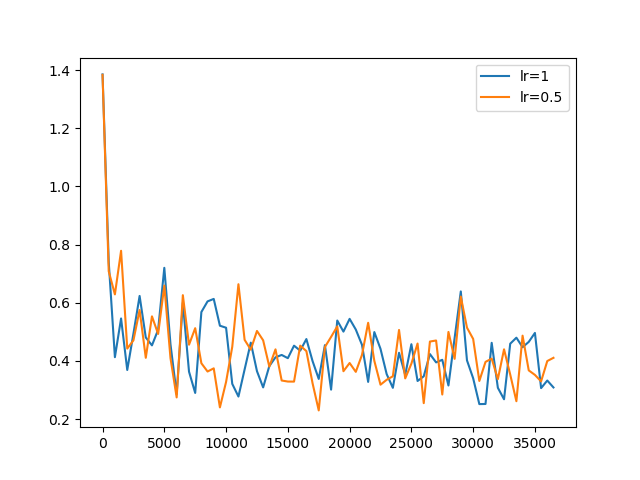

In [8]:
fig, ax = plt.subplots()
for lr, ph in zip(learning_rate, performance_history):
    ax.plot(ph['iter'],ph['loss'],label='lr={:.2g}'.format(lr))
    
ax.legend()

# Entrenamiento de word vectors para clasificación

## Pretraining

### CBOW

In [4]:
class WordEmbeddingAGNewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, root='./AG_NEWS/', preprocess=lambda x: x, n_window=2, train=True):
        
        target = 'train.csv' if train else 'test.csv'
        df = pd.read_csv(root + target, header=None, names=['class_idx', 'title', 'description'])
        data = preprocess(df['title'])
        samples = data.apply(self._get_context, n_window=n_window)
        self.data = pd.DataFrame([[subsample[0], subsample[1]] for sample in samples for subsample in sample],
                                 columns=['word','context'])
    
    def __getitem__(self,idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        context_vector = self.vectorizer.vectorize(self.data['context'].iloc[idx])
        word_index = self.vectorizer.vocabulary.token_to_index(self.data['word'].iloc[idx])
        return context_vector, word_index
    
    def _get_context(self,sentence,n_window):
        
        no_sentence = '<NS>'
        samples = []
        for i, word in enumerate(sentence):
            first_context_word_index = max(0,i-n_window)
            last_context_word_index = min(i+n_window+1, len(sentence))

            context = [no_sentence for j in range(i-n_window,first_context_word_index)] + \
                      sentence[first_context_word_index:i] + \
                      sentence[i+1:last_context_word_index] + \
                      [no_sentence for j in range(last_context_word_index,i+n_window+1)]
            
            samples.append((word,context))

        return samples
    
    
    def __len__(self):
        return len(self.data)
    
    
def GetAGNewsWordEmbeddingsDataset(root, preprocess, n_window=2, cutoff=25):
    
    # Datasets:
    train_dataset = WordEmbeddingAGNewsDataset(root, preprocess=preprocess, n_window=2, train=True)
    train_dataset.vectorizer = Vectorizer([train_dataset.data['word']], cutoff=cutoff)
    test_dataset = WordEmbeddingAGNewsDataset(root, preprocess=preprocess, n_window=2, train=False)
    test_dataset.vectorizer = train_dataset.vectorizer
    
    # Dataloaders:
    train_dataloader, val_dataloader, test_dataloader = generate_data_batches(train_dataset, 
                                                                              test_dataset,    
                                                                              batch_size=64)
    return train_dataloader, val_dataloader, test_dataloader


def preprocess(data):
    df = data.str.replace(r'\(AP\)','')
    df = df.str.replace(r'\(Reuters\)','')
    df = df.str.replace(r'\(AFP\)','')
    df = df.str.replace(r'\(SPACE\.com\)','')
    df = df.str.replace(r'\ba\b','')
    df = df.str.replace(r'\bthe\b','')
    df = df.str.replace(r'\bis\b','')
    df = df.str.replace(r'\bof\b','')
    df = df.str.replace(r'\bto\b','')
    df = df.str.replace(r'[,:;\?\!\"]','')
    df = df.str.replace(r'\s+','<SEP>')
    df = df.str.replace(r"'s<SEP>","<SEP>'s<SEP>")
    df = df.str.split('<SEP>')
    return df


we_train_dataloader, we_val_dataloader, we_test_dataloader = GetAGNewsWordEmbeddingsDataset(root='./AG_NEWS/', 
                                                                               preprocess=preprocess, 
                                                                               cutoff=25)

In [10]:
import torch.nn as nn

class Word2VecCBOW(nn.Module):
    
    def __init__(self, vocab_size, n_embeddings):
        super(Word2VecCBOW, self).__init__()
        self.emb = nn.Linear(vocab_size, n_embeddings)
        self.out = nn.Linear(n_embeddings, vocab_size)
        
    def forward(self, x):
        return self.out(self.emb(x))
    
    def loss(self, scores, target):
        lf = nn.CrossEntropyLoss()
        return lf(scores, target)

### Skip-Gram

In [2]:
class WordEmbeddingAGNewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, root='./AG_NEWS/', preprocess=lambda x: x, n_window=2, train=True):
        
        target = 'train.csv' if train else 'test.csv'
        df = pd.read_csv(root + target, header=None, names=['class_idx', 'title', 'description'])
        data = preprocess(df['title'])
        samples = data.apply(self._get_context, n_window=n_window)
        self.data = pd.DataFrame([[subsample[0], subsample[1]] for sample in samples for subsample in sample],
                                 columns=['word','context'])
        self.n_window = n_window
    
    def __getitem__(self,idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        word_vector = self.vectorizer.vectorize(self.data['word'].iloc[idx])
        context_indeces = torch.zeros(2*self.n_window, dtype=torch.long)
        for i, token in enumerate(self.data['context'].iloc[idx]):
            context_indeces[i] = self.vectorizer.vocabulary.token_to_index(token)
        return word_vector, context_indeces
    
    def _get_context(self,sentence,n_window):
        
        no_sentence = '<NS>'
        samples = []
        for i, word in enumerate(sentence):
            first_context_word_index = max(0,i-n_window)
            last_context_word_index = min(i+n_window+1, len(sentence))

            context = [no_sentence for j in range(i-n_window,first_context_word_index)] + \
                      sentence[first_context_word_index:i] + \
                      sentence[i+1:last_context_word_index] + \
                      [no_sentence for j in range(last_context_word_index,i+n_window+1)]
            
            samples.append((word,context))

        return samples
    
    
    def __len__(self):
        return len(self.data)
    
    
def GetAGNewsWordEmbeddingsDataset(root, preprocess, n_window=2, cutoff=25):
    
    # Datasets:
    train_dataset = WordEmbeddingAGNewsDataset(root, preprocess=preprocess, n_window=2, train=True)
    train_dataset.vectorizer = Vectorizer([train_dataset.data['word']], cutoff=cutoff)
    test_dataset = WordEmbeddingAGNewsDataset(root, preprocess=preprocess, n_window=2, train=False)
    test_dataset.vectorizer = train_dataset.vectorizer
    
    # Dataloaders:
    train_dataloader, val_dataloader, test_dataloader = generate_data_batches(train_dataset, 
                                                                              test_dataset,    
                                                                              batch_size=64)
    return train_dataloader, val_dataloader, test_dataloader


def preprocess(data):
    df = data.str.replace(r'\(AP\)','')
    df = df.str.replace(r'\(Reuters\)','')
    df = df.str.replace(r'\(AFP\)','')
    df = df.str.replace(r'\(SPACE\.com\)','')
    df = df.str.replace(r'\ba\b','')
    df = df.str.replace(r'\bthe\b','')
    df = df.str.replace(r'\bis\b','')
    df = df.str.replace(r'\bof\b','')
    df = df.str.replace(r'\bto\b','')
    df = df.str.replace(r'[,:;\?\!\"]','')
    df = df.str.replace(r'\s+','<SEP>')
    df = df.str.replace(r"'s<SEP>","<SEP>'s<SEP>")
    df = df.str.split('<SEP>')
    return df


we_train_dataloader, we_val_dataloader, we_test_dataloader = GetAGNewsWordEmbeddingsDataset(root='./AG_NEWS/', 
                                                                               preprocess=preprocess, 
                                                                               cutoff=25)

In [3]:
import torch.nn as nn

class Word2VecSkipGram(nn.Module):
    
    def __init__(self, vocab_size, n_embeddings, n_window):
        super(Word2VecSkipGram, self).__init__()
        self.emb = nn.Linear(vocab_size, n_embeddings)
        self.out = nn.Linear(n_embeddings, vocab_size)
        self.window_size = n_window
        self.vocab_size = vocab_size
        
    def forward(self, x):
        return self.out(self.emb(x))
    
    def loss(self, scores, target):
        lf = nn.CrossEntropyLoss()
        scores = scores.view(-1,self.vocab_size,1).repeat(1,1,2*self.window_size)
        return lf(scores, target)

In [29]:
scores = torch.tensor([[1,2],[4,5],[7,8]],dtype=torch.float)
target = torch.tensor([[1,1,0],[0,0,1],[0,1,1]])
model = Word2VecSkipGram(2,20,2)
model.loss(scores,target)

x1 = nn.functional.cross_entropy(torch.tensor([[1,2],[4,5],[7,8]],dtype=torch.float),
                                 torch.tensor([1,0,0]))
x2 = nn.functional.cross_entropy(torch.tensor([[1,2],[4,5],[7,8]],dtype=torch.float),
                                 torch.tensor([1,0,1]))
x3 = nn.functional.cross_entropy(torch.tensor([[1,2],[4,5],[7,8]],dtype=torch.float),
                                 torch.tensor([0,1,1]))
(x1 + x2 + x3)/3 == model.loss(scores,target)

tensor([[[1., 1., 1.],
         [2., 2., 2.]],

        [[4., 4., 4.],
         [5., 5., 5.]],

        [[7., 7., 7.],
         [8., 8., 8.]]])


tensor(True)

In [4]:
# Parámetros de las muestras:
data = {
    'use_gpu': True, # Trasladar o no las muestras a la GPU
    'input_dtype': torch.float, # Tipo de dato de las muestras de entrada
    'target_dtype': torch.long, # Tipo de dato de las muestras de salida
    'train_dataloader': we_train_dataloader, # Dataset de entrenamiento
    'val_dataloader': we_val_dataloader # Dataset de validación
}

# Parámetros de optimización:
epochs = 40 # Cantidad de epochs
sample_loss_every = 500 # Cantidad de iteraciones para calcular la cantidad de aciertos
learning_rate = [5e-1] # Tasa de aprendizaje
check_on_train = False # Queremos ver los resultados también en el train set

# Entrenamiento:
models = []
performance_history = []

n_classes = 4
vocab_size = len(we_train_dataloader.dataset.vectorizer.vocabulary)
n_embeddings = 100
EmbeddingModel = Word2VecSkipGram(vocab_size, n_embeddings, n_window=2)

for lr in learning_rate:
    model = Word2VecSkipGram(vocab_size, n_embeddings, n_window=2)
    model.load_state_dict(EmbeddingModel.state_dict())
    performance_history.append(SGDTrainModel(model, 
                                             data, 
                                             epochs, 
                                             lr, 
                                             sample_loss_every, 
                                             check_on_train, 
                                             verbose=True))
    models.append(model)
    print('lr={:.2g} completed.'.format(lr))

KeyError: 'the token <NS> is not in the Vocabulary'

<IPython.core.display.Javascript object>


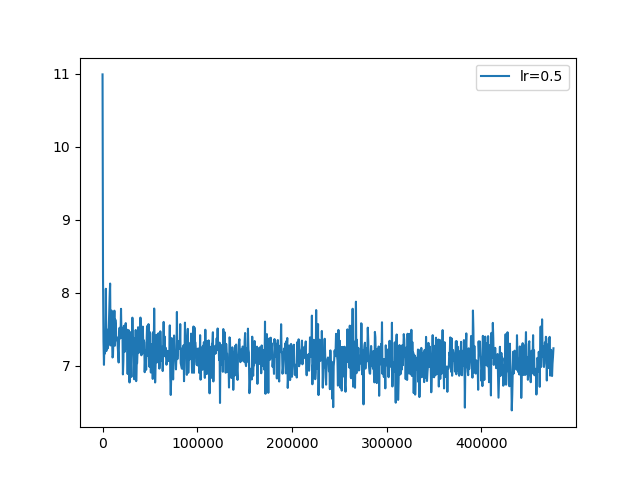

In [49]:
fig, ax = plt.subplots()
for lr, ph in zip(learning_rate, performance_history):
    ax.plot(ph['iter'],ph['loss'],label='lr={:.2g}'.format(lr))
    
ax.legend()

## Finetuning

In [53]:
class AGNewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, root='./AG_NEWS/', preprocess=lambda x: x, train=True):
        
        target = 'train.csv' if train else 'test.csv'
        df = pd.read_csv(root + target, header=None, names=['class_idx', 'title', 'description'])
        
        # Etiquetas:
        self.cls_indeces = torch.tensor(df['class_idx'].tolist(), dtype=torch.long) - 1
        
        # DataSeries con las muestras de entradas:
        data = df['title']
        self.data = preprocess(data)
    
    def __getitem__(self,idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        return self.vectorizer.vectorize(self.data.iloc[idx]), self.cls_indeces[idx]
    
    def __len__(self):
        return len(self.cls_indeces)
    
    
def GetAGNewsDataset(root, preprocess, cutoff=25):
    
    # Datasets:
    train_dataset = AGNewsDataset(root, preprocess=preprocess, train=True)
    train_dataset.vectorizer = Vectorizer([train_dataset.data], cutoff=cutoff)
    test_dataset = AGNewsDataset(root, preprocess=preprocess, train=False)
    test_dataset.vectorizer = train_dataset.vectorizer
    
    # Dataloaders:
    train_dataloader, val_dataloader, test_dataloader = generate_data_batches(train_dataset, 
                                                                              test_dataset,    
                                                                              batch_size=64)
    return train_dataloader, val_dataloader, test_dataloader

In [54]:
tc_train_dataloader, tc_val_dataloader, tc_test_dataloader = GetAGNewsDataset(root='./AG_NEWS/', 
                                                                     preprocess=preprocess, 
                                                                     cutoff=25)

import torch.nn as nn

class TextClassifier(nn.Module):
    
    def __init__(self, EmbeddingLayer, n_classes):
        super(TextClassifier, self).__init__()
        self.emb = nn.Linear(EmbeddingLayer.in_features, EmbeddingLayer.out_features)
        self.out = nn.Linear(EmbeddingLayer.out_features, n_classes)
        
    def forward(self, x):
        return self.out(self.emb(x))
    
    def loss(self, scores, target):
        lf = nn.CrossEntropyLoss()
        return lf(scores, target)

In [55]:
# Parámetros de las muestras:
data = {
    'use_gpu': True, # Trasladar o no las muestras a la GPU
    'input_dtype': torch.float, # Tipo de dato de las muestras de entrada
    'target_dtype': torch.long, # Tipo de dato de las muestras de salida
    'train_dataloader': tc_train_dataloader, # Dataset de entrenamiento
    'val_dataloader': tc_val_dataloader # Dataset de validación
}

# Parámetros de optimización:
epochs = 20 # Cantidad de epochs
sample_loss_every = 1000 # Cantidad de iteraciones para calcular la cantidad de aciertos
learning_rate = [1e-1] # Tasa de aprendizaje
check_on_train = False # Queremos ver los resultados también en el train set

# Entrenamiento:
performance_history = []
n_classes = 4
BestEmbeddingModel = models[0]
classification_models = []
ClassifierModel = TextClassifier(BestEmbeddingModel.emb, n_classes)
ClassifierModel.load_state_dict({
    'emb.weight': BestEmbeddingModel.state_dict()['emb.weight'],
    'emb.bias': BestEmbeddingModel.state_dict()['emb.bias'],
    'out.weight': ClassifierModel.state_dict()['out.weight'],
    'out.bias': ClassifierModel.state_dict()['out.bias']
})
for lr in learning_rate:
    model = TextClassifier(BestEmbeddingModel.emb, n_classes)
    model.load_state_dict(ClassifierModel.state_dict())
    for param in model.emb.parameters():
        param.requires_grad = False
    performance_history.append(SGDTrainModel(model, 
                                             data, 
                                             epochs, 
                                             lr, 
                                             sample_loss_every, 
                                             check_on_train, 
                                             verbose=True))
    classification_models.append(model)
    print('lr={:.2g} completed.'.format(lr))

Epoch: 0, Batch number: 0
Accuracy on validation dataset: 624/2400 (26.00%)

Epoch: 0, Batch number: 1000
Accuracy on validation dataset: 603/2400 (25.12%)

Epoch: 1, Batch number: 162
Accuracy on validation dataset: 607/2400 (25.29%)

Epoch: 1, Batch number: 1162
Accuracy on validation dataset: 596/2400 (24.83%)

Epoch: 2, Batch number: 324
Accuracy on validation dataset: 616/2400 (25.67%)

Epoch: 2, Batch number: 1324
Accuracy on validation dataset: 645/2400 (26.88%)

Epoch: 3, Batch number: 486
Accuracy on validation dataset: 594/2400 (24.75%)

Epoch: 3, Batch number: 1486
Accuracy on validation dataset: 602/2400 (25.08%)

Epoch: 4, Batch number: 648
Accuracy on validation dataset: 642/2400 (26.75%)

Epoch: 4, Batch number: 1648
Accuracy on validation dataset: 629/2400 (26.21%)

Epoch: 5, Batch number: 810
Accuracy on validation dataset: 616/2400 (25.67%)

Epoch: 5, Batch number: 1810
Accuracy on validation dataset: 616/2400 (25.67%)

Epoch: 6, Batch number: 972
Accuracy on validati

<IPython.core.display.Javascript object>


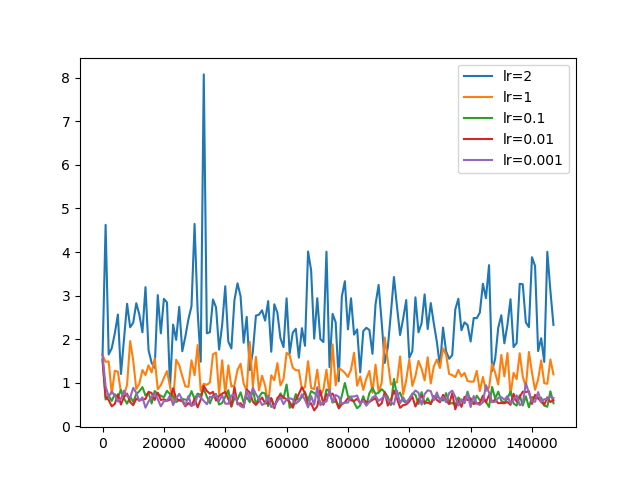

In [18]:
fig, ax = plt.subplots()
for lr, ph in zip(learning_rate, performance_history):
    ax.plot(ph['iter'],ph['loss'],label='lr={:.2g}'.format(lr))
    
ax.legend()